In [1]:
import h5py
import pylab as pl
import numpy as np
import matplotlib.colors as mpc
import networkx
import ipyvolume as ipv
import scipy.stats as sp
import progressbar

In [2]:
pl.rc('font', size = 20)
pl.rc('legend', fontsize = 20)

In [3]:
def split_unique_id(unique_id):
    """Splits the ids assign to the subhalos by the merger tree code by snap number and subfind number """
    subfind_number = int(unique_id % 1e6)
    snap_number = int((unique_id - subfind_number) / 1e6)
    
    return snap_number, subfind_number

def get_main_branch_unique_ids(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    i = 0
    while True:
        succesors = list(subtree.successors(node))
        if len(succesors) == 0:
            break
        node = succesors[0] # select only the first succesor (main branch)
        mpb.append(node)
        
    return mpb

def get_main_branch_and_progNumb(subtree, node):
    """Gets the unique ids of the subhalos belonging to the main branch of the selected subhalo (node)"""
    mpb = [node, ]
    numb = [[node], ]
    i = 0
    while True:
        successors = list(subtree.successors(node))
        if len(successors) == 0:
            break
        node = successors[0] # select only the first succesor (main branch)
        mpb.append(node)
        numb.append(successors)
        
    return mpb, numb


def set_view(figure, framenr, fraction):
    ipv.view(fraction*360, 0.)
    
def set_angles(fig, i, fraction):
    fig.angley = fraction*np.pi*2

# a bunch of constants
UnitMass_in_g = 1.989e+43
UnitTime_in_s = 3.08568e+16
UnitVelocity_in_cm_per_s = 100000
UnitDensity_in_cgs = 6.7699e-22
UnitEnergy_in_cgs = 1.989e+53
GAMMA_MINUS1 = 2./3.
PROTONMASS = 1.6726e-24
BOLTZMANN = 1.3806e-16    

HMass = 1.00794
FeMass = 55.845
OMass = 15.9994
NfeNhe_sun = -4.5 # grevesse & saundall 98
NoNfe_sun = 1.33 # same

def tempFromMass(Mass, Abund, IE, ne1):
    XH = Abund[:,6]/Mass
    yHelium = (1. - XH)/(4.*XH)
    mu = (1 + 4.* yHelium)/ (1.+ yHelium + ne1 )
    temp = GAMMA_MINUS1 * IE * mu * 1.6726 / 1.3806 * 1.e-8 # / BOLTZMANN  * PROTONMASS
    temp = temp * 1e10 #   UnitEnergy_in_cgs / UnitMass_in_g;
    return temp


def modemod(x):
    mo = sps.mode(x)
    return mo.mode[0]

def getCentre(group):
    MassDM = sim['SnapNumber_128/Header/MassTable'][1]
    OffDM = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
    OffGas = sim['SnapNumber_128/Groups/PartType0/Offsets'][group].astype('int')
    OffStars = sim['SnapNumber_128/Groups/PartType0/Offsets'][group].astype('int')
    
    VelDM = sim['SnapNumber_128/PartType1/Velocities'][OffDM[0]:OffDM[1]]
    VelGas = sim['SnapNumber_128/PartType0/Velocities'][OffGas[0]:OffGas[1]]
    VelStars = sim['SnapNumber_128/PartType4/Velocities'][OffStars[0]:OffStars[1]]
    
    PosDM = sim['SnapNumber_128/PartType1/Coordinates'][OffDM[0]:OffDM[1]]
    PosGas = sim['SnapNumber_128/PartType0/Coordinates'][OffGas[0]:OffGas[1]]
    PosStars = sim['SnapNumber_128/PartType4/Coordinates'][OffStars[0]:OffStars[1]]
    
    MassDM = np.ones(OffDM[1]-OffDM[0])*MassDM
    MassGas = sim['SnapNumber_128/PartType0/Masses'][OffGas[0]:OffGas[1]]
    MassStars = sim['SnapNumber_128/PartType4/Masses'][OffStars[0]:OffStars[1]]
    
    X = list(PosDM[:,0])
    X.extend(list(PosGas[:,0]))
    X.extend(list(PosStars[:,0]))
    X = np.array(X)
    
    Y = list(PosDM[:,1])
    Y.extend(list(PosGas[:,1]))
    Y.extend(list(PosStars[:,1]))
    Y = np.array(Y)
    
    Z = list(PosDM[:,2])
    Z.extend(list(PosGas[:,2]))
    Z.extend(list(PosStars[:,2]))
    Z = np.array(Z)
    
    XV = list(VelDM[:,0])
    XV.extend(list(VelGas[:,0]))
    XV.extend(list(VelStars[:,0]))
    XV = np.array(XV)
    
    YV = list(VelDM[:,1])
    YV.extend(list(VelGas[:,1]))
    YV.extend(list(VelStars[:,1]))
    YV = np.array(YV)
    
    ZV = list(VelDM[:,2])
    ZV.extend(list(VelGas[:,2]))
    ZV.extend(list(VelStars[:,2]))
    ZV = np.array(ZV)
    
    Mass = list(MassDM)
    Mass.extend(list(MassGas))
    Mass.extend(list(MassStars))
    Mass = np.array(Mass)
    
    XC = np.average(X, weights=Mass)
    YC = np.average(Y, weights=Mass)
    ZC = np.average(Z, weights=Mass)
    
    XVC = np.average(XV, weights=Mass)
    YVC = np.average(YV, weights=Mass)
    ZVC = np.average(ZV, weights=Mass)
    
    return np.array([XC, YC, ZC]), np.array([XVC, YVC, ZVC])

In [4]:
sim = h5py.File('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1.hdf5', 'r')
trees = networkx.read_multiline_adjlist('/disk1/data1-casona/data1/cielo/simulations/LG1/LG1_tree.dat')

In [5]:
def plotPhaseSpace(fofID, centralID):
    
    uniqueID = int(127*1e6+fofID)
    stree = networkx.dfs_tree(trees, str(uniqueID))
    mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
    uniqueC = int(127*1e6+centralID)
    streeC = networkx.dfs_tree(trees, str(uniqueC))
    mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
    Idlist = []
    
    for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
        snap, idd = split_unique_id(int(mm))
        snapC, iddC = split_unique_id(int(mmC))
        tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
        pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
        if snapC==snap:
            pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
        if tempOff[0]>= 0 and tempOff[1]>=0:
            tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            
            
#             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

#             posPart = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
#             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

#             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

#             rr = np.sqrt(xx**2+yy**2+zz**2)

#             ik = np.where(rr<rop)[0]
            
#             tempIds = tempIds[ik]
            Idlist.extend(list(tempIds))
            
    #Idlist, vallist = np.array(Idlist), np.array(vallist)
    Idlist = np.array(Idlist)
    Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
    #vallist = vallist[Idunique]
    
    # the total list of particles that once belong to a give subgroup, lest see where are today.
    TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
    TdayCoord = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

    TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]
    
    IndexToday = np.in1d(TdayTotalIDs, Idlist)
    IndexToday_ = np.where(IndexToday)[0]
    
    #remove the ones that are not part of the group today.

    TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
      
    IndexNot = np.in1d(Idlist, TdayIDs)
    IdNot = Idlist[np.where(IndexNot==False)[0]]

    IndexT = np.in1d(TdayTotalIDs, IdNot)
    IndexT_ = np.where(IndexT)[0]

    
    #valorder_near = valorder[icut]
    IndexT_near = IndexT_
    #valorder_near = valorder
    
    #and the current status
    Status = np.zeros(IndexT_near.size)
    
    Thegroup = sim['SnapNumber_128/SubGroups/GroupNumber'][fofID]
    gro = sim['SnapNumber_128/SubGroups/GroupNumber'][centralID]
    
    PartGroup = sim['SnapNumber_128/PartType0/GroupNumber'][IndexT_near]
    PartSubGroup = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
    ICM = np.where((PartGroup == Thegroup) & (PartSubGroup ==-1))
    
    IndexT_near = IndexT_near[ICM]
    
    # here i make the cut.
    return IndexT_near

In [6]:
# ok, lets see the particles that are part of the ICM
group1 = sim['SnapNumber_128/SubGroups/GroupNumber'][4337]
group2 = sim['SnapNumber_128/SubGroups/GroupNumber'][4469]

r200_1 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group1]
r200_2 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group2]

group1, group2

(4671, 4672)

In [7]:
# group1
Ggroups = sim['SnapNumber_128/PartType0/GroupNumber'][()]
CSubGroup = sim['SnapNumber_128/PartType0/SubGroupNumber'][()]

igrou1 = np.where((Ggroups==group1) & (CSubGroup==-1))[0]

# ccen1 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4337]

ccen1, vcen1 = getCentre(group1)

pospart1 = sim['SnapNumber_128/PartType0/Coordinates'][igrou1]

xx1, yy1, zz1 = pospart1[:,0] - ccen1[0], pospart1[:,1] - ccen1[1], pospart1[:,2] - ccen1[2]
rr1 = np.sqrt(xx1**2+yy1**2+zz1**2)

Abund1 = sim['SnapNumber_128/PartType0/Abundances'][igrou1]

In [8]:
# group2
igrou2 = np.where((Ggroups==group2) & (CSubGroup==-1))[0]

# ccen2 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4469]
ccen2, vcen2 = getCentre(group2)

pospart2 = sim['SnapNumber_128/PartType0/Coordinates'][igrou2]

xx2, yy2, zz2 = pospart2[:,0] - ccen2[0], pospart2[:,1] - ccen2[1], pospart2[:,2] - ccen2[2]
rr2 = np.sqrt(xx2**2+yy2**2+zz2**2)

Abund2 = sim['SnapNumber_128/PartType0/Abundances'][igrou2]

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, '[O/Fe]')

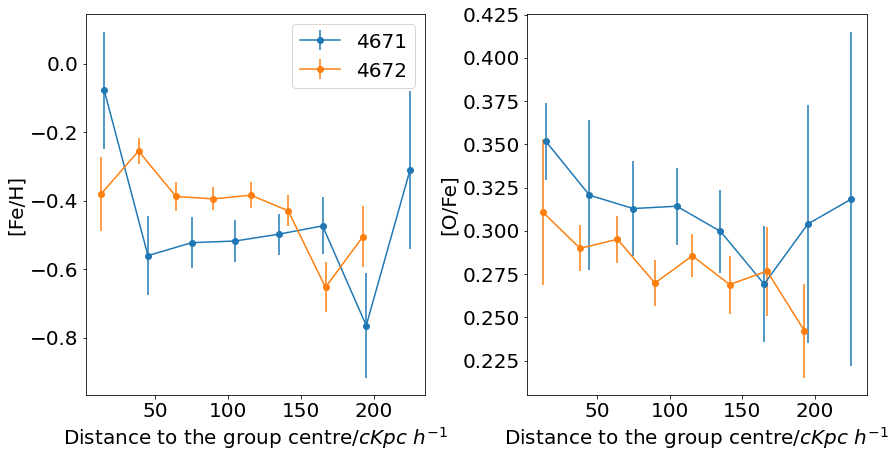

In [9]:
FeH1 = np.log10((Abund1[:,4]/FeMass)/(Abund1[:,6]/HMass)) - NfeNhe_sun
OFe1 = np.log10((Abund1[:,3]/OMass)/(Abund1[:,4]/FeMass)) - NoNfe_sun

FeH2 = np.log10((Abund2[:,4]/FeMass)/(Abund2[:,6]/HMass)) - NfeNhe_sun
OFe2 = np.log10((Abund2[:,3]/OMass)/(Abund2[:,4]/FeMass)) - NoNfe_sun

i11 = np.where((np.isnan(FeH1)==False) & (np.isinf(FeH1)==False))
i12 = np.where((np.isnan(OFe1)==False) & (np.isinf(OFe1)==False))

i21 = np.where((np.isnan(FeH2)==False) & (np.isinf(FeH2)==False))
i22 = np.where((np.isnan(OFe2)==False) & (np.isinf(OFe2)==False))


rr11_c, FeH1 = rr1[i11], FeH1[i11]
rr21_c, OFe1 = rr1[i12], OFe1[i12]

rr12_c, FeH2 = rr2[i21], FeH2[i21]
rr22_c, OFe2 = rr2[i22], OFe2[i22]


mFeH1, bins1, zipC1 = sp.binned_statistic(rr11_c, FeH1, statistic='median', bins=8, range=(0, 1.5*r200_1))
stdFeH1, bins1, zipC1 = sp.binned_statistic(rr11_c, FeH1, statistic='std', bins=8, range=(0, 1.5*r200_1))
numbFeH1, bins1, zipC1 = sp.binned_statistic(rr11_c, FeH1, statistic='count', bins=8, range=(0, 1.5*r200_1))

errFeH1 = stdFeH1/np.sqrt(numbFeH1) * np.sqrt(np.pi/2.)

x_xFeH1 = .5*(bins1[:-1]+bins1[1:])

mOFe1, bins1, zipC1 = sp.binned_statistic(rr21_c, OFe1, statistic='median', bins=8, range=(0, 1.5*r200_1))
stdOFe1, bins1, zipC1 = sp.binned_statistic(rr21_c, OFe1, statistic='std', bins=8, range=(0, 1.5*r200_1))
numbOFe1, bins1, zipC1 = sp.binned_statistic(rr21_c, OFe1, statistic='count', bins=8, range=(0, 1.5*r200_1))

errOFe1 = stdOFe1/np.sqrt(numbOFe1) * np.sqrt(np.pi/2.)

x_xOFe1 = .5*(bins1[:-1]+bins1[1:])


mFeH2, bins2, zipC2 = sp.binned_statistic(rr12_c, FeH2, statistic='median', bins=8, range=(0, 1.5*r200_2))
stdFeH2, bins2, zipC2 = sp.binned_statistic(rr12_c, FeH2, statistic='std', bins=8, range=(0, 1.5*r200_2))
numbFeH2, bins2, zipC2 = sp.binned_statistic(rr12_c, FeH2, statistic='count', bins=8, range=(0, 1.5*r200_2))

errFeH2 = stdFeH2/np.sqrt(numbFeH2) * np.sqrt(np.pi/2.)

x_xFeH2 = .5*(bins2[:-1]+bins2[1:])

mOFe2, bins2, zipC2 = sp.binned_statistic(rr22_c, OFe2, statistic='median', bins=8, range=(0, 1.5*r200_2))
stdOFe2, bins2, zipC2 = sp.binned_statistic(rr22_c, OFe2, statistic='std', bins=8, range=(0, 1.5*r200_2))
numbOFe2, bins2, zipC2 = sp.binned_statistic(rr22_c, OFe2, statistic='count', bins=8, range=(0, 1.5*r200_2))

errOFe2 = stdOFe2/np.sqrt(numbOFe2) * np.sqrt(np.pi/2.)

x_xOFe2 = .5*(bins2[:-1]+bins2[1:])


pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

pl.subplot(1, 2, 1)

pl.errorbar(x_xFeH1, mFeH1, yerr=errFeH1, marker='o', label=group1)
pl.errorbar(x_xFeH2, mFeH2, yerr=errFeH2, marker='o', label=group2)

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]')

pl.legend(loc='best')

pl.subplot(1, 2, 2)

pl.errorbar(x_xOFe1, mOFe1, yerr=errOFe1, marker='o', label=group1)
pl.errorbar(x_xOFe2, mOFe2, yerr=errOFe2, marker='o', label=group2)

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]')

In [10]:
# ok, that was, something, lets remove the ones that are stripped from galaxies
IDs1 = []

groups = sim['SnapNumber_128/SubGroups/GroupNumber'][()]
sat1 = np.where(groups==group1)[0][1:]

pbar = progressbar.ProgressBar(max_value=sat1.size)

for i, ss in enumerate(sat1):
    try:
        ids = plotPhaseSpace(ss, 4337)
    except KeyError:
        continue
    IDs1.extend(list(ids))
    pbar.update(i)
    
IDs1 = np.array(IDs1)

 99% (130 of 131) |##################### | Elapsed Time: 0:03:22 ETA:   0:00:00

In [11]:
IDs2 = []

sat2 = np.where(groups==group2)[0][1:]

pbar = progressbar.ProgressBar(max_value=sat2.size)

for i, ss in enumerate(sat2):
    try:
        ids = plotPhaseSpace(ss, 4469)
    except KeyError:
        continue
    IDs2.extend(list(ids))
    pbar.update(i)
    
IDs2 = np.array(IDs2)

 99% (157 of 158) |##################### | Elapsed Time: 0:06:23 ETA:   0:00:00

In [12]:
IDs1 = np.unique(IDs1)
IDs2 = np.unique(IDs2)

In [13]:
PIDs1 = sim['SnapNumber_128/PartType0/ParticleIDs'][igrou1]
PIDs2 = sim['SnapNumber_128/PartType0/ParticleIDs'][igrou2]

PIDs1_not = sim['SnapNumber_128/PartType0/ParticleIDs'][IDs1]
PIDs2_not = sim['SnapNumber_128/PartType0/ParticleIDs'][IDs2]

In [14]:
PIDs1.size, PIDs1_not.size, PIDs2.size, PIDs2_not.size 

(9161, 982, 27424, 9368)

In [15]:
there1 = np.isin(PIDs1, PIDs1_not)
there2 = np.isin(PIDs2, PIDs2_not)

theren1 = np.where(there1==False)[0]
theren2 = np.where(there2==False)[0]

rr1N, AbundN1 = rr1[theren1], Abund1[theren1]
rr2N, AbundN2 = rr2[theren2], Abund2[theren2]

rr1N.size-rr1.size, rr2N.size-rr2.size

(-982, -9368)

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, '[O/Fe]')

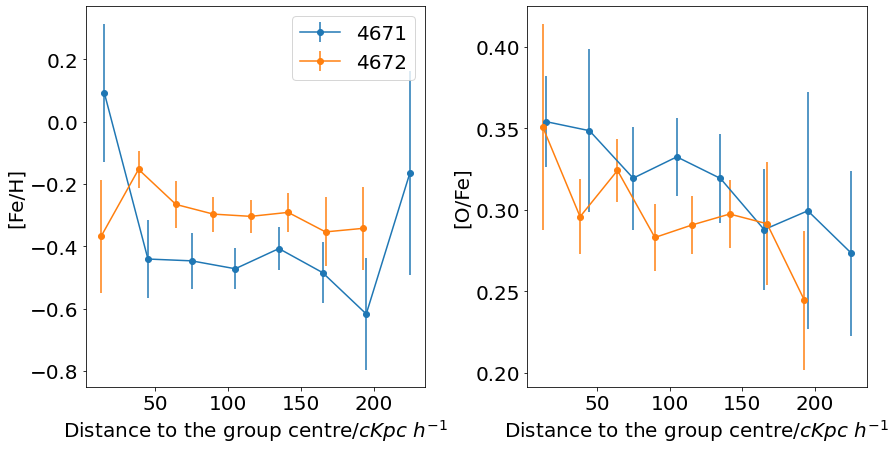

In [16]:
FeH1N = np.log10((AbundN1[:,4]/FeMass)/(AbundN1[:,6]/HMass)) - NfeNhe_sun
OFe1N = np.log10((AbundN1[:,3]/OMass)/(AbundN1[:,4]/FeMass)) - NoNfe_sun

FeH2N = np.log10((AbundN2[:,4]/FeMass)/(AbundN2[:,6]/HMass)) - NfeNhe_sun
OFe2N = np.log10((AbundN2[:,3]/OMass)/(AbundN2[:,4]/FeMass)) - NoNfe_sun

i11N = np.where((np.isnan(FeH1N)==False) & (np.isinf(FeH1N)==False))
i12N = np.where((np.isnan(OFe1N)==False) & (np.isinf(OFe1N)==False))

i21N = np.where((np.isnan(FeH2N)==False) & (np.isinf(FeH2N)==False))
i22N = np.where((np.isnan(OFe2N)==False) & (np.isinf(OFe2N)==False))


rr11_cN, FeH1N = rr1N[i11N], FeH1N[i11N]
rr21_cN, OFe1N = rr1N[i12N], OFe1N[i12N]

rr12_cN, FeH2N = rr2N[i21N], FeH2N[i21N]
rr22_cN, OFe2N = rr2N[i22N], OFe2N[i22N]


mFeH1N, bins1N, zipC1N = sp.binned_statistic(rr11_cN, FeH1N, statistic='median', bins=8, range=(0, 1.5*r200_1))
stdFeH1N, bins1N, zipC1N = sp.binned_statistic(rr11_cN, FeH1N, statistic='std', bins=8, range=(0, 1.5*r200_1))
numbFeH1N, bins1N, zipC1N = sp.binned_statistic(rr11_cN, FeH1N, statistic='count', bins=8, range=(0, 1.5*r200_1))

errFeH1N = stdFeH1N/np.sqrt(numbFeH1N) * np.sqrt(np.pi/2.)

x_xFeH1N = .5*(bins1N[:-1]+bins1N[1:])

mOFe1N, bins1N, zipC1N = sp.binned_statistic(rr21_cN, OFe1N, statistic='median', bins=8, range=(0, 1.5*r200_1))
stdOFe1N, bins1N, zipC1N = sp.binned_statistic(rr21_cN, OFe1N, statistic='std', bins=8, range=(0, 1.5*r200_1))
numbOFe1N, bins1N, zipC1N = sp.binned_statistic(rr21_cN, OFe1N, statistic='count', bins=8, range=(0, 1.5*r200_1))

errOFe1N = stdOFe1N/np.sqrt(numbOFe1N) * np.sqrt(np.pi/2.)

x_xOFe1N = .5*(bins1N[:-1]+bins1N[1:])


mFeH2N, bins2N, zipC2N = sp.binned_statistic(rr12_cN, FeH2N, statistic='median', bins=8, range=(0, 1.5*r200_2))
stdFeH2N, bins2N, zipC2N = sp.binned_statistic(rr12_cN, FeH2N, statistic='std', bins=8, range=(0, 1.5*r200_2))
numbFeH2N, bins2N, zipC2N = sp.binned_statistic(rr12_cN, FeH2N, statistic='count', bins=8, range=(0, 1.5*r200_2))

errFeH2N = stdFeH2N/np.sqrt(numbFeH2N) * np.sqrt(np.pi/2.)

x_xFeH2N = .5*(bins2N[:-1]+bins2N[1:])

mOFe2N, bins2N, zipC2N = sp.binned_statistic(rr22_cN, OFe2N, statistic='median', bins=8, range=(0, 1.5*r200_2))
stdOFe2N, bins2N, zipC2N = sp.binned_statistic(rr22_cN, OFe2N, statistic='std', bins=8, range=(0, 1.5*r200_2))
numbOFe2N, bins2N, zipC2N = sp.binned_statistic(rr22_cN, OFe2N, statistic='count', bins=8, range=(0, 1.5*r200_2))

errOFe2N = stdOFe2N/np.sqrt(numbOFe2N) * np.sqrt(np.pi/2.)

x_xOFe2N = .5*(bins2N[:-1]+bins2N[1:])


pl.figure(figsize=(14, 7))

pl.subplots_adjust(wspace=0.3)

pl.subplot(1, 2, 1)

pl.errorbar(x_xFeH1N, mFeH1N, yerr=errFeH1N, marker='o', label=group1)
pl.errorbar(x_xFeH2N, mFeH2N, yerr=errFeH2N, marker='o', label=group2)

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]')

pl.legend(loc='best')

pl.subplot(1, 2, 2)

pl.errorbar(x_xOFe1N, mOFe1N, yerr=errOFe1N, marker='o', label=group1)
pl.errorbar(x_xOFe2N, mOFe2N, yerr=errOFe2N, marker='o', label=group2)

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]')

Text(0, 0.5, '[O/Fe]')

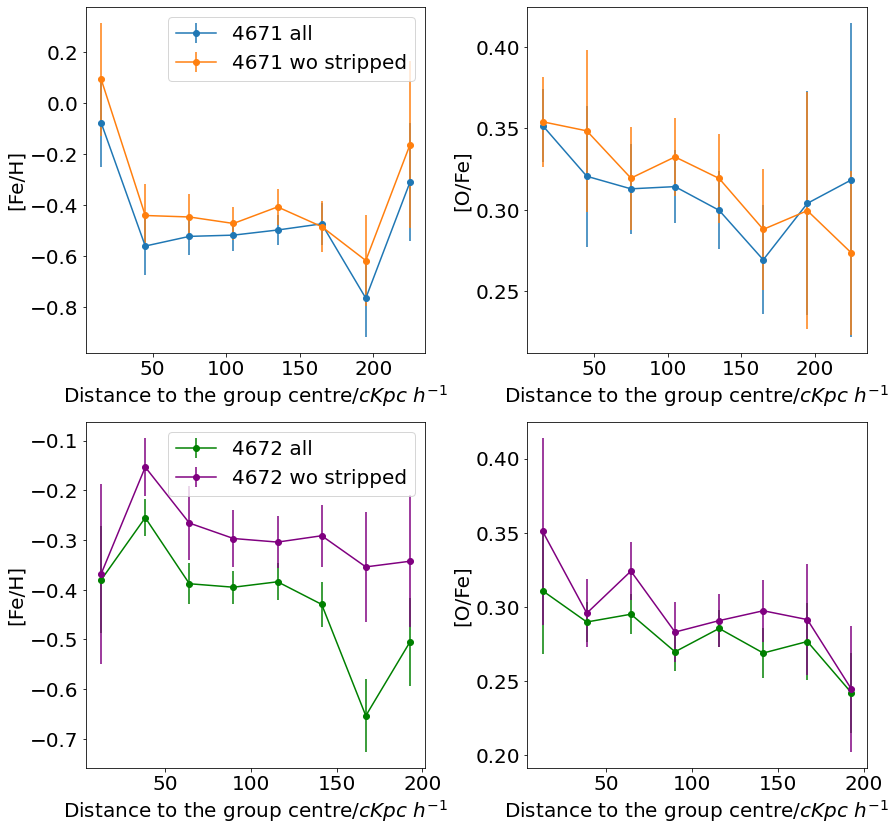

In [17]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.3)

pl.subplot(2, 2, 1)

pl.errorbar(x_xFeH1, mFeH1, yerr=errFeH1, marker='o', label='{} all'.format(group1))
pl.errorbar(x_xFeH1N, mFeH1N, yerr=errFeH1N, marker='o', label='{} wo stripped'.format(group1))

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]')

pl.legend(loc='best')

pl.subplot(2, 2, 3)

pl.errorbar(x_xFeH2, mFeH2, yerr=errFeH2, marker='o', label='{} all'.format(group2), color='green')
pl.errorbar(x_xFeH2N, mFeH2N, yerr=errFeH2N, marker='o', label='{} wo stripped'.format(group2), color='purple')

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]')

pl.legend(loc='best')

pl.subplot(2, 2, 2)

pl.errorbar(x_xOFe1, mOFe1, yerr=errOFe1, marker='o')
pl.errorbar(x_xOFe1N, mOFe1N, yerr=errOFe1N, marker='o')

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]')

pl.subplot(2, 2, 4)


pl.errorbar(x_xOFe2, mOFe2, yerr=errOFe2, marker='o', color='green')
pl.errorbar(x_xOFe2N, mOFe2N, yerr=errOFe2N, marker='o', color='purple')


pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]')

In [18]:
there1 = np.isin(PIDs1, PIDs1_not)
there2 = np.isin(PIDs2, PIDs2_not)

thereis1 = np.where(there1)[0]
thereis2 = np.where(there2)[0]

rr1Y, AbundY1 = rr1[thereis1], Abund1[thereis1]
rr2Y, AbundY2 = rr2[thereis2], Abund2[thereis2]

In [19]:
FeH1Y = np.log10((AbundY1[:,4]/FeMass)/(AbundY1[:,6]/HMass)) - NfeNhe_sun
OFe1Y = np.log10((AbundY1[:,3]/OMass)/(AbundY1[:,4]/FeMass)) - NoNfe_sun

FeH2Y = np.log10((AbundY2[:,4]/FeMass)/(AbundY2[:,6]/HMass)) - NfeNhe_sun
OFe2Y = np.log10((AbundY2[:,3]/OMass)/(AbundY2[:,4]/FeMass)) - NoNfe_sun

i11Y = np.where((np.isnan(FeH1Y)==False) & (np.isinf(FeH1Y)==False))
i12Y = np.where((np.isnan(OFe1Y)==False) & (np.isinf(OFe1Y)==False))

i21Y = np.where((np.isnan(FeH2Y)==False) & (np.isinf(FeH2Y)==False))
i22Y = np.where((np.isnan(OFe2Y)==False) & (np.isinf(OFe2Y)==False))


rr11_cY, FeH1Y = rr1Y[i11Y], FeH1Y[i11Y]
rr21_cY, OFe1Y = rr1Y[i12Y], OFe1Y[i12Y]

rr12_cY, FeH2Y = rr2Y[i21Y], FeH2Y[i21Y]
rr22_cY, OFe2Y = rr2Y[i22Y], OFe2Y[i22Y]


mFeH1Y, bins1Y, zipC1Y = sp.binned_statistic(rr11_cY, FeH1Y, statistic='median', bins=8, range=(0, 1.5*r200_1))
stdFeH1Y, bins1Y, zipC1Y = sp.binned_statistic(rr11_cY, FeH1Y, statistic='std', bins=8, range=(0, 1.5*r200_1))
numbFeH1Y, bins1Y, zipC1Y = sp.binned_statistic(rr11_cY, FeH1Y, statistic='count', bins=8, range=(0, 1.5*r200_1))

errFeH1Y = stdFeH1Y/np.sqrt(numbFeH1Y) * np.sqrt(np.pi/2.)

x_xFeH1Y = .5*(bins1Y[:-1]+bins1Y[1:])

mOFe1Y, bins1Y, zipC1Y = sp.binned_statistic(rr21_cY, OFe1Y, statistic='median', bins=8, range=(0, 1.5*r200_1))
stdOFe1Y, bins1Y, zipC1Y = sp.binned_statistic(rr21_cY, OFe1Y, statistic='std', bins=8, range=(0, 1.5*r200_1))
numbOFe1Y, bins1Y, zipC1Y = sp.binned_statistic(rr21_cY, OFe1Y, statistic='count', bins=8, range=(0, 1.5*r200_1))

errOFe1Y = stdOFe1Y/np.sqrt(numbOFe1Y) * np.sqrt(np.pi/2.)

x_xOFe1Y = .5*(bins1Y[:-1]+bins1Y[1:])


mFeH2Y, bins2Y, zipC2Y = sp.binned_statistic(rr12_cY, FeH2Y, statistic='median', bins=8, range=(0, 1.5*r200_2))
stdFeH2Y, bins2Y, zipC2Y = sp.binned_statistic(rr12_cY, FeH2Y, statistic='std', bins=8, range=(0, 1.5*r200_2))
numbFeH2Y, bins2Y, zipC2Y = sp.binned_statistic(rr12_cY, FeH2Y, statistic='count', bins=8, range=(0, 1.5*r200_2))

errFeH2Y = stdFeH2Y/np.sqrt(numbFeH2Y) * np.sqrt(np.pi/2.)

x_xFeH2Y = .5*(bins2Y[:-1]+bins2Y[1:])

mOFe2Y, bins2Y, zipC2Y = sp.binned_statistic(rr22_cY, OFe2Y, statistic='median', bins=8, range=(0, 1.5*r200_2))
stdOFe2Y, bins2Y, zipC2Y = sp.binned_statistic(rr22_cY, OFe2Y, statistic='std', bins=8, range=(0, 1.5*r200_2))
numbOFe2Y, bins2Y, zipC2Y = sp.binned_statistic(rr22_cY, OFe2Y, statistic='count', bins=8, range=(0, 1.5*r200_2))

errOFe2Y = stdOFe2Y/np.sqrt(numbOFe2Y) * np.sqrt(np.pi/2.)

x_xOFe2Y = .5*(bins2Y[:-1]+bins2Y[1:])

/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/srodriguez/miniconda3/envs/cielo_old/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


Text(0, 0.5, '[O/Fe]')

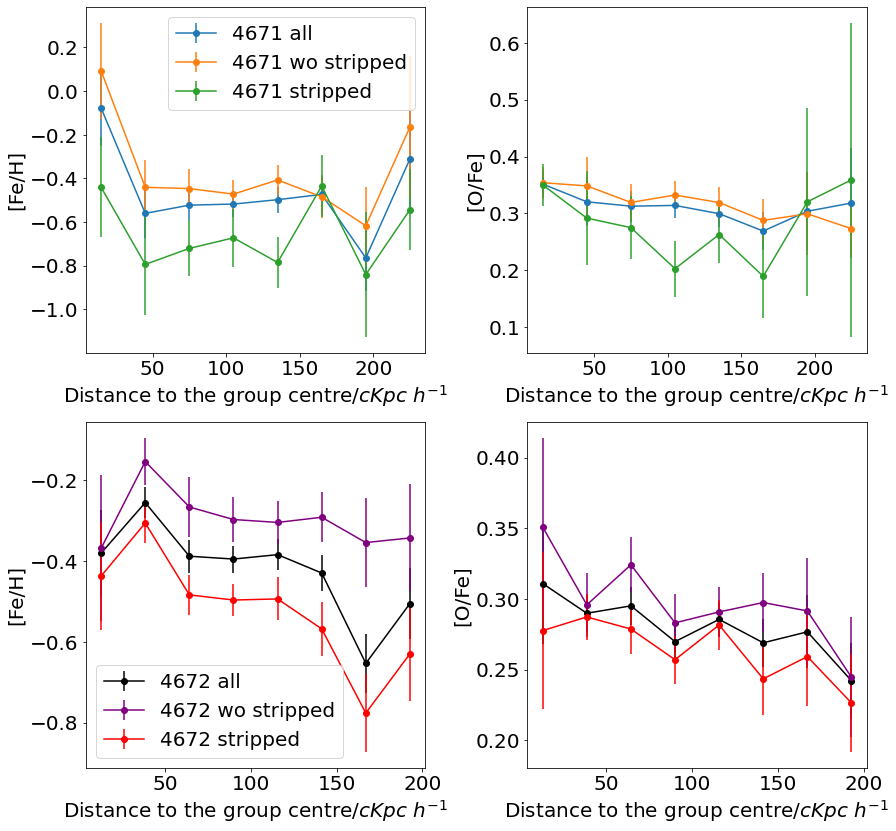

In [20]:
pl.figure(figsize=(14, 14))

pl.subplots_adjust(wspace=0.3)

pl.subplot(2, 2, 1)

pl.errorbar(x_xFeH1, mFeH1, yerr=errFeH1, marker='o', label='{} all'.format(group1))
pl.errorbar(x_xFeH1N, mFeH1N, yerr=errFeH1N, marker='o', label='{} wo stripped'.format(group1))
pl.errorbar(x_xFeH1Y, mFeH1Y, yerr=errFeH1Y, marker='o', label='{} stripped'.format(group1))

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]')

pl.legend(loc='best')

pl.subplot(2, 2, 3)

pl.errorbar(x_xFeH2, mFeH2, yerr=errFeH2, marker='o', label='{} all'.format(group2), color='black')
pl.errorbar(x_xFeH2N, mFeH2N, yerr=errFeH2N, marker='o', label='{} wo stripped'.format(group2), color='purple')
pl.errorbar(x_xFeH2Y, mFeH2Y, yerr=errFeH2Y, marker='o', label='{} stripped'.format(group2), color='red')

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[Fe/H]')

pl.legend(loc='best')

pl.subplot(2, 2, 2)

pl.errorbar(x_xOFe1, mOFe1, yerr=errOFe1, marker='o')
pl.errorbar(x_xOFe1N, mOFe1N, yerr=errOFe1N, marker='o')
pl.errorbar(x_xOFe1Y, mOFe1Y, yerr=errOFe1Y, marker='o')

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]')

pl.subplot(2, 2, 4)


pl.errorbar(x_xOFe2, mOFe2, yerr=errOFe2, marker='o', color='black')
pl.errorbar(x_xOFe2N, mOFe2N, yerr=errOFe2N, marker='o', color='purple')
pl.errorbar(x_xOFe2Y, mOFe2Y, yerr=errOFe2Y, marker='o', color='red')

pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
pl.ylabel('[O/Fe]')

In [21]:
# r200_1 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group1]
# r200_2 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group2]

Text(0, 0.5, '[O/Fe]')

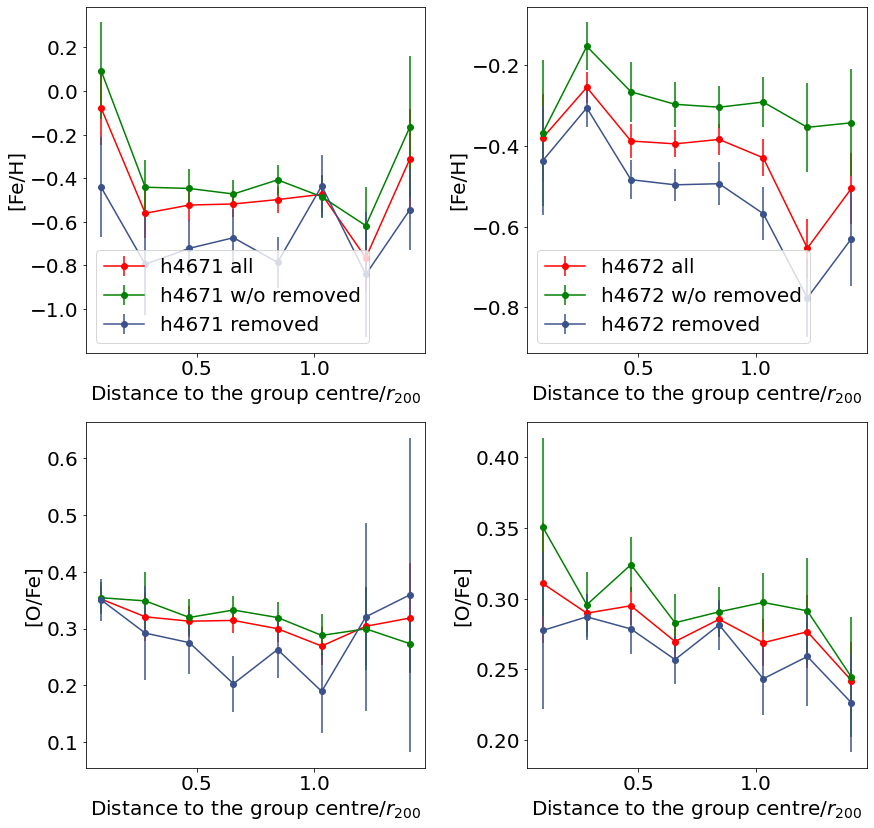

In [22]:
pl.figure(figsize=(14, 14))

cIGM = (0.231674, 0.318106, 0.544834, 1.0)

pl.subplots_adjust(wspace=0.3)

pl.subplot(2, 2, 1)

pl.errorbar(x_xFeH1/r200_1, mFeH1, yerr=errFeH1, marker='o', label='h{} all'.format(group1), color='red')
pl.errorbar(x_xFeH1N/r200_1, mFeH1N, yerr=errFeH1N, marker='o', label='h{} w/o removed'.format(group1), color='green')
pl.errorbar(x_xFeH1Y/r200_1, mFeH1Y, yerr=errFeH1Y, marker='o', label='h{} removed'.format(group1), color=cIGM)

# pl.text(0.25,0.1, '{}'.format(group1))

pl.xlabel('Distance to the group centre$/r_{200}$')
pl.ylabel('[Fe/H]')

pl.legend(loc=3)

pl.subplot(2, 2, 2)

pl.errorbar(x_xFeH2/r200_2, mFeH2, yerr=errFeH2, marker='o', label='h{} all'.format(group2), color='red')
pl.errorbar(x_xFeH2N/r200_2, mFeH2N, yerr=errFeH2N, marker='o', label='h{} w/o removed'.format(group2), color='green')
pl.errorbar(x_xFeH2Y/r200_2, mFeH2Y, yerr=errFeH2Y, marker='o', label='h{} removed'.format(group2), color=cIGM)

pl.xlabel('Distance to the group centre$/r_{200}$')
pl.ylabel('[Fe/H]')

# pl.text(0.25,0.1, '{}'.format(group2))

pl.legend(loc=3)

pl.subplot(2, 2, 3)

pl.errorbar(x_xOFe1/r200_1, mOFe1, yerr=errOFe1, marker='o', color='red')
pl.errorbar(x_xOFe1N/r200_1, mOFe1N, yerr=errOFe1N, marker='o', color='green')
pl.errorbar(x_xOFe1Y/r200_1, mOFe1Y, yerr=errOFe1Y, marker='o', color=cIGM)

pl.xlabel('Distance to the group centre$/r_{200}$')
pl.ylabel('[O/Fe]')

# pl.text(0.25, 0.65, '{}'.format(group1))

pl.subplot(2, 2, 4)

pl.errorbar(x_xOFe2/r200_2, mOFe2, yerr=errOFe2, marker='o', color='red')
pl.errorbar(x_xOFe2N/r200_2, mOFe2N, yerr=errOFe2N, marker='o', color='green')
pl.errorbar(x_xOFe2Y/r200_2, mOFe2Y, yerr=errOFe2Y, marker='o', color=cIGM)

# pl.text(0.25,0.65, '{}'.format(group2))

pl.xlabel('Distance to the group centre$/r_{200}$')
pl.ylabel('[O/Fe]')

In [23]:
# GroupList = sim['SnapNumber_128/Groups/GroupNumber'][()]
# GroupList.size

In [24]:
# bar = progressbar.ProgressBar(max_value=GroupList.size)

# RsTot, AbundTot = [], []
# RsWO, AbundWO = [], []
# RsAr, AbundAr = [], []

# for cc, group in enumerate(GroupList):
#     igrou = np.where((Ggroups==group) & (CSubGroup==-1))[0]

#     try:
#         cen = np.where(groups==group)[0][0]
#     except IndexError:
#         continue
#     ccen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
#     pospart = sim['SnapNumber_128/PartType0/Coordinates'][igrou]

#     xx, yy, zz = pospart[:,0] - ccen[0], pospart[:,1] - ccen[1], pospart[:,2] - ccen[2]
#     rr = np.sqrt(xx**2+yy**2+zz**2)

#     Abund = sim['SnapNumber_128/PartType0/Abundances'][igrou]
#     r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
#     rr = rr/r200
    
#     RsTot.extend(list(rr))
#     AbundTot.extend(list(Abund))
    
#     sat = np.where(groups==group)[0][1:]
    
#     IDs = []
#     for ss in sat:
#         ids = plotPhaseSpace(ss, cen)
#         IDs.extend(list(ids))
    
#     IDs = np.array(IDs)
#     IDs = np.unique(IDs)
    
#     PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][igrou]

#     PIDs_not = sim['SnapNumber_128/PartType0/ParticleIDs'][IDs]
    
#     there = np.isin(PIDs, PIDs_not)
#     theren = np.where(there==False)[0]
#     rrN, AbundN = rr[theren], Abund[theren]
    
#     RsWO.extend(list(rrN))
#     AbundWO.extend(list(AbundN))
    
#     thereis = np.where(there)[0]
#     rrY, AbundY = rr[thereis], Abund[thereis]
    
#     RsAr.extend(list(rrY))
#     AbundAr.extend(list(AbundY))
    
#     bar.update(cc+1)
    
# RsTot, AbundTot = np.array(RsTot), np.array(AbundTot)
# RsWO, AbundWO = np.array(RsWO), np.array(AbundWO)
# RsAr, AbundAr = np.array(RsAr), np.array(AbundAr)

In [25]:
# FeHY = np.log10((AbundAr[:,4]/FeMass)/(AbundAr[:,6]/HMass)) - NfeNhe_sun
# OFeY = np.log10((AbundAr[:,3]/OMass)/(AbundAr[:,4]/FeMass)) - NoNfe_sun

# FeH = np.log10((AbundTot[:,4]/FeMass)/(AbundTot[:,6]/HMass)) - NfeNhe_sun
# OFe = np.log10((AbundTot[:,3]/OMass)/(AbundTot[:,4]/FeMass)) - NoNfe_sun

# FeHN = np.log10((AbundWO[:,4]/FeMass)/(AbundWO[:,6]/HMass)) - NfeNhe_sun
# OFeN = np.log10((AbundWO[:,3]/OMass)/(AbundWO[:,4]/FeMass)) - NoNfe_sun

# i1Y = np.where((np.isnan(FeHY)==False) & (np.isinf(FeHY)==False))
# i2Y = np.where((np.isnan(OFeY)==False) & (np.isinf(OFeY)==False))

# i1N = np.where((np.isnan(FeHN)==False) & (np.isinf(FeHN)==False))
# i2N = np.where((np.isnan(OFeN)==False) & (np.isinf(OFeN)==False))

# i1 = np.where((np.isnan(FeH)==False) & (np.isinf(FeH)==False))
# i2 = np.where((np.isnan(OFe)==False) & (np.isinf(OFe)==False))

# rrFeH_Y, FeHY = RsAr[i1Y], FeHY[i1Y]
# rrOFe_Y, OFeY = RsAr[i2Y], OFeY[i2Y]

# mFeHY, binsY, zipCY = sp.binned_statistic(rrFeH_Y, FeHY, statistic='median', bins=10, range=(0,2))
# stdFeHY, binsY, zipCY = sp.binned_statistic(rrFeH_Y, FeHY, statistic='std', bins=10, range=(0,2))
# numbFeHY, binsY, zipCY = sp.binned_statistic(rrFeH_Y, FeHY, statistic='count', bins=10, range=(0,2))
# errFeHY = stdFeHY/np.sqrt(numbFeHY) * np.sqrt(np.pi/2.)
# x_xFeHY = .5*(binsY[:-1]+binsY[1:])

# mOFeY, binsY, zipCY = sp.binned_statistic(rrOFe_Y, OFeY, statistic='median', bins=10, range=(0,2))
# stdOFeY, binsY, zipCY = sp.binned_statistic(rrOFe_Y, OFeY, statistic='std', bins=10, range=(0,2))
# numbOFeY, binsY, zipCY = sp.binned_statistic(rrOFe_Y, OFeY, statistic='count', bins=10, range=(0,2))
# errOFeY = stdOFeY/np.sqrt(numbOFeY) * np.sqrt(np.pi/2.)
# x_xOFeY = .5*(binsY[:-1]+binsY[1:])

# rrFeH_N, FeHN = RsWO[i1N], FeHN[i1N]
# rrOFe_N, OFeN = RsWO[i2N], OFeN[i2N]

# ifinitFeH_N = np.where(np.isinf(rrFeH_N)==False)
# ifinitOFe_N = np.where(np.isinf(rrOFe_N)==False)

# rrFeH_N, FeHN = rrFeH_N[ifinitFeH_N], FeHN[ifinitFeH_N]
# rrOFe_N, OFeN = rrOFe_N[ifinitOFe_N], OFeN[ifinitOFe_N]

# mFeHN, binsN, zipCN = sp.binned_statistic(rrFeH_N, FeHN, statistic='median', bins=10, range=(0,2))
# stdFeHN, binsN, zipCN = sp.binned_statistic(rrFeH_N, FeHN, statistic='std', bins=10, range=(0,2))
# numbFeHN, binsN, zipCN = sp.binned_statistic(rrFeH_N, FeHN, statistic='count', bins=10, range=(0,2))
# errFeHN = stdFeHN/np.sqrt(numbFeHN) * np.sqrt(np.pi/2.)
# x_xFeHN = .5*(binsN[:-1]+binsN[1:])

# mOFeN, binsN, zipCN = sp.binned_statistic(rrOFe_N, OFeN, statistic='median', bins=10, range=(0,2))
# stdOFeN, binsN, zipCN = sp.binned_statistic(rrOFe_N, OFeN, statistic='std', bins=10, range=(0,2))
# numbOFeN, binsN, zipCN = sp.binned_statistic(rrOFe_N, OFeN, statistic='count', bins=10, range=(0,2))
# errOFeN = stdOFeN/np.sqrt(numbOFeN) * np.sqrt(np.pi/2.)
# x_xOFeN = .5*(binsN[:-1]+binsN[1:])

# rrFeH_, FeH = RsTot[i1], FeH[i1]
# rrOFe_, OFe = RsTot[i2], OFe[i2]

# ifinitFeH = np.where(np.isinf(rrFeH_)==False)
# ifinitOFe = np.where(np.isinf(rrOFe_)==False)

# rrFeH_, FeH = rrFeH_[ifinitFeH], FeH[ifinitFeH]
# rrOFe_, OFe = rrOFe_[ifinitOFe], OFe[ifinitOFe]

# mFeH, bins, zipC = sp.binned_statistic(rrFeH_, FeH, statistic='median', bins=10, range=(0,2))
# stdFeH, bins, zipC = sp.binned_statistic(rrFeH_, FeH, statistic='std', bins=10, range=(0,2))
# numbFeH, bins, zipC = sp.binned_statistic(rrFeH_, FeH, statistic='count', bins=10, range=(0,2))
# errFeH = stdFeH/np.sqrt(numbFeH) * np.sqrt(np.pi/2.)
# x_xFeH = .5*(bins[:-1]+bins[1:])

# mOFe, bins, zipC = sp.binned_statistic(rrOFe_, OFe, statistic='median', bins=10, range=(0,2))
# stdOFe, bins, zipC = sp.binned_statistic(rrOFe_, OFe, statistic='std', bins=10, range=(0,2))
# numbOFe, bins, zipC = sp.binned_statistic(rrOFe_, OFe, statistic='count', bins=10, range=(0,2))
# errOFe = stdOFe/np.sqrt(numbOFe) * np.sqrt(np.pi/2.)
# x_xOFe = .5*(bins[:-1]+bins[1:])

In [26]:
# pl.figure(figsize=(14, 7))

# pl.subplots_adjust(wspace=0.3)

# pl.subplot(1,2,1)

# pl.errorbar(x_xFeH, mFeH, yerr=errFeH, marker='o', label='all')
# pl.errorbar(x_xFeHN, mFeHN, yerr=errFeHN, marker='o', label='w/o stripped')
# pl.errorbar(x_xFeHY, mFeHY, yerr=errFeHY, marker='o', label='stripped')

# pl.xlabel('Distance to the group centre$/r_{200}$')
# pl.ylabel('[Fe/H]')

# pl.legend(loc='best')

# pl.subplot(1,2,2)

# pl.errorbar(x_xOFe, mOFe, yerr=errOFe, marker='o', label='all')
# pl.errorbar(x_xOFeN, mOFeN, yerr=errOFeN, marker='o', label='w/o stripped')
# pl.errorbar(x_xOFeY, mOFeY, yerr=errOFeY, marker='o', label='stripped')

# pl.xlabel('Distance to the group centre$/r_{200}$')
# pl.ylabel('[O/Fe]')

In [27]:
# R200, M200 = [], []

# for cc, group in enumerate(GroupList):
#     m200 = sim['SnapNumber_128/Groups/Group_M_Crit200'][group]
#     r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
#     R200.append(r200)
#     M200.append(np.log10(m200*1e10))
    
# R200, M200 = np.array(R200), np.array(M200)

In [28]:
# pl.figure(figsize=(14, 7))

# pl.subplot(1,2,1)

# pl.hist(R200, bins=100)
# pl.yscale('log')


# pl.subplot(1, 2, 2)

# pl.hist(M200, range=(5, 12), bins=100)
# # pl.yscale('log')
# # pl.xscale('log')

In [29]:
# medMass = np.median(M200)

# i = np.where(M200>11)
# GListMass = GroupList[i]

In [30]:
# R200, M200 = [], []

# for cc, group in enumerate(GListMass):
#     m200 = sim['SnapNumber_128/Groups/Group_M_Crit200'][group]
#     r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
#     R200.append(r200)
#     M200.append(np.log10(m200*1e10))
    
# R200, M200 = np.array(R200), np.array(M200)

In [31]:
# pl.figure(figsize=(14, 7))

# pl.subplot(1,2,1)

# pl.hist(np.log10(R200), bins=100)
# pl.yscale('log')


# pl.subplot(1, 2, 2)

# pl.hist(M200, range=(5, 14), bins=100)
# # pl.yscale('log')
# # pl.xscale('log')

# M200

In [32]:
# R200.min()

In [33]:
# bar = progressbar.ProgressBar(max_value=GListMass.size)

# RsTot, AbundTot = [], []
# RsWO, AbundWO = [], []
# RsAr, AbundAr = [], []

# for cc, group in enumerate(GListMass):
#     igrou = np.where((Ggroups==group) & (CSubGroup==-1))[0]

#     try:
#         cen = np.where(groups==group)[0][0]
#     except IndexError:
#         continue
#     ccen = sim['SnapNumber_128/SubGroups/SubGroupPos'][cen]
#     pospart = sim['SnapNumber_128/PartType0/Coordinates'][igrou]

#     xx, yy, zz = pospart[:,0] - ccen[0], pospart[:,1] - ccen[1], pospart[:,2] - ccen[2]
#     rr = np.sqrt(xx**2+yy**2+zz**2)

#     Abund = sim['SnapNumber_128/PartType0/Abundances'][igrou]
#     r200 = sim['SnapNumber_128/Groups/Group_R_Crit200'][group]
    
#     rr = rr/r200
    
#     RsTot.extend(list(rr))
#     AbundTot.extend(list(Abund))
    
#     sat = np.where(groups==group)[0][1:]
    
#     IDs = []
#     for ss in sat:
#         ids = plotPhaseSpace(ss, cen)
#         IDs.extend(list(ids))
    
#     IDs = np.array(IDs)
#     IDs = np.unique(IDs)
    
#     PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][igrou]

#     PIDs_not = sim['SnapNumber_128/PartType0/ParticleIDs'][IDs]
    
#     there = np.isin(PIDs, PIDs_not)
#     theren = np.where(there==False)[0]
#     rrN, AbundN = rr[theren], Abund[theren]
    
#     RsWO.extend(list(rrN))
#     AbundWO.extend(list(AbundN))
    
#     thereis = np.where(there)[0]
#     rrY, AbundY = rr[thereis], Abund[thereis]
    
#     RsAr.extend(list(rrY))
#     AbundAr.extend(list(AbundY))
    
#     bar.update(cc+1)
    
# RsTot, AbundTot = np.array(RsTot), np.array(AbundTot)
# RsWO, AbundWO = np.array(RsWO), np.array(AbundWO)
# RsAr, AbundAr = np.array(RsAr), np.array(AbundAr)

In [34]:
# FeHY = np.log10((AbundAr[:,4]/FeMass)/(AbundAr[:,6]/HMass)) - NfeNhe_sun
# OFeY = np.log10((AbundAr[:,3]/OMass)/(AbundAr[:,4]/FeMass)) - NoNfe_sun

# FeH = np.log10((AbundTot[:,4]/FeMass)/(AbundTot[:,6]/HMass)) - NfeNhe_sun
# OFe = np.log10((AbundTot[:,3]/OMass)/(AbundTot[:,4]/FeMass)) - NoNfe_sun

# FeHN = np.log10((AbundWO[:,4]/FeMass)/(AbundWO[:,6]/HMass)) - NfeNhe_sun
# OFeN = np.log10((AbundWO[:,3]/OMass)/(AbundWO[:,4]/FeMass)) - NoNfe_sun

# i1Y = np.where((np.isnan(FeHY)==False) & (np.isinf(FeHY)==False))
# i2Y = np.where((np.isnan(OFeY)==False) & (np.isinf(OFeY)==False))

# i1N = np.where((np.isnan(FeHN)==False) & (np.isinf(FeHN)==False))
# i2N = np.where((np.isnan(OFeN)==False) & (np.isinf(OFeN)==False))

# i1 = np.where((np.isnan(FeH)==False) & (np.isinf(FeH)==False))
# i2 = np.where((np.isnan(OFe)==False) & (np.isinf(OFe)==False))

# rrFeH_Y, FeHY = RsAr[i1Y], FeHY[i1Y]
# rrOFe_Y, OFeY = RsAr[i2Y], OFeY[i2Y]

# mFeHY, binsY, zipCY = sp.binned_statistic(rrFeH_Y, FeHY, statistic='median', bins=10, range=(0,2))
# stdFeHY, binsY, zipCY = sp.binned_statistic(rrFeH_Y, FeHY, statistic='std', bins=10, range=(0,2))
# numbFeHY, binsY, zipCY = sp.binned_statistic(rrFeH_Y, FeHY, statistic='count', bins=10, range=(0,2))
# errFeHY = stdFeHY/np.sqrt(numbFeHY) * np.sqrt(np.pi/2.)
# x_xFeHY = .5*(binsY[:-1]+binsY[1:])

# mOFeY, binsY, zipCY = sp.binned_statistic(rrOFe_Y, OFeY, statistic='median', bins=10, range=(0,2))
# stdOFeY, binsY, zipCY = sp.binned_statistic(rrOFe_Y, OFeY, statistic='std', bins=10, range=(0,2))
# numbOFeY, binsY, zipCY = sp.binned_statistic(rrOFe_Y, OFeY, statistic='count', bins=10, range=(0,2))
# errOFeY = stdOFeY/np.sqrt(numbOFeY) * np.sqrt(np.pi/2.)
# x_xOFeY = .5*(binsY[:-1]+binsY[1:])

# rrFeH_N, FeHN = RsWO[i1N], FeHN[i1N]
# rrOFe_N, OFeN = RsWO[i2N], OFeN[i2N]

# ifinitFeH_N = np.where(np.isinf(rrFeH_N)==False)
# ifinitOFe_N = np.where(np.isinf(rrOFe_N)==False)

# rrFeH_N, FeHN = rrFeH_N[ifinitFeH_N], FeHN[ifinitFeH_N]
# rrOFe_N, OFeN = rrOFe_N[ifinitOFe_N], OFeN[ifinitOFe_N]

# mFeHN, binsN, zipCN = sp.binned_statistic(rrFeH_N, FeHN, statistic='median', bins=10, range=(0,2))
# stdFeHN, binsN, zipCN = sp.binned_statistic(rrFeH_N, FeHN, statistic='std', bins=10, range=(0,2))
# numbFeHN, binsN, zipCN = sp.binned_statistic(rrFeH_N, FeHN, statistic='count', bins=10, range=(0,2))
# errFeHN = stdFeHN/np.sqrt(numbFeHN) * np.sqrt(np.pi/2.)
# x_xFeHN = .5*(binsN[:-1]+binsN[1:])

# mOFeN, binsN, zipCN = sp.binned_statistic(rrOFe_N, OFeN, statistic='median', bins=10, range=(0,2))
# stdOFeN, binsN, zipCN = sp.binned_statistic(rrOFe_N, OFeN, statistic='std', bins=10, range=(0,2))
# numbOFeN, binsN, zipCN = sp.binned_statistic(rrOFe_N, OFeN, statistic='count', bins=10, range=(0,2))
# errOFeN = stdOFeN/np.sqrt(numbOFeN) * np.sqrt(np.pi/2.)
# x_xOFeN = .5*(binsN[:-1]+binsN[1:])

# rrFeH_, FeH = RsTot[i1], FeH[i1]
# rrOFe_, OFe = RsTot[i2], OFe[i2]

# ifinitFeH = np.where(np.isinf(rrFeH_)==False)
# ifinitOFe = np.where(np.isinf(rrOFe_)==False)

# rrFeH_, FeH = rrFeH_[ifinitFeH], FeH[ifinitFeH]
# rrOFe_, OFe = rrOFe_[ifinitOFe], OFe[ifinitOFe]

# mFeH, bins, zipC = sp.binned_statistic(rrFeH_, FeH, statistic='median', bins=10, range=(0,2))
# stdFeH, bins, zipC = sp.binned_statistic(rrFeH_, FeH, statistic='std', bins=10, range=(0,2))
# numbFeH, bins, zipC = sp.binned_statistic(rrFeH_, FeH, statistic='count', bins=10, range=(0,2))
# errFeH = stdFeH/np.sqrt(numbFeH) * np.sqrt(np.pi/2.)
# x_xFeH = .5*(bins[:-1]+bins[1:])

# mOFe, bins, zipC = sp.binned_statistic(rrOFe_, OFe, statistic='median', bins=10, range=(0,2))
# stdOFe, bins, zipC = sp.binned_statistic(rrOFe_, OFe, statistic='std', bins=10, range=(0,2))
# numbOFe, bins, zipC = sp.binned_statistic(rrOFe_, OFe, statistic='count', bins=10, range=(0,2))
# errOFe = stdOFe/np.sqrt(numbOFe) * np.sqrt(np.pi/2.)
# x_xOFe = .5*(bins[:-1]+bins[1:])

In [35]:
# pl.figure(figsize=(14, 7))

# pl.subplots_adjust(wspace=0.3)

# pl.subplot(1,2,1)

# pl.errorbar(x_xFeH, mFeH, yerr=errFeH, marker='o', label='all')
# pl.errorbar(x_xFeHN, mFeHN, yerr=errFeHN, marker='o', label='w/o stripped')
# pl.errorbar(x_xFeHY, mFeHY, yerr=errFeHY, marker='o', label='stripped')

# pl.xlabel('Distance to the group centre$/r_{200}$')
# pl.ylabel('[Fe/H]')

# pl.legend(loc='best')

# pl.subplot(1,2,2)

# pl.errorbar(x_xOFe, mOFe, yerr=errOFe, marker='o', label='all')
# pl.errorbar(x_xOFeN, mOFeN, yerr=errOFeN, marker='o', label='w/o stripped')
# pl.errorbar(x_xOFeY, mOFeY, yerr=errOFeY, marker='o', label='stripped')

# pl.xlabel('Distance to the group centre$/r_{200}$')
# pl.ylabel('[O/Fe]')

In [36]:
# # i gonna select the most massive group
# MTOT = []
# DMmass = sim['SnapNumber_128/Header/MassTable'][1]

# for cc, group in enumerate(GroupList):
#     OFFGas = sim['SnapNumber_128/Groups/PartType0/Offsets'][group].astype('int')
#     OFFDM = sim['SnapNumber_128/Groups/PartType1/Offsets'][group].astype('int')
#     OFFStars = sim['SnapNumber_128/Groups/PartType4/Offsets'][group].astype('int')
#     StarMass = np.sum(sim['SnapNumber_128/PartType4/Masses'][OFFStars[0]:OFFStars[1]])
#     GMass = sim['SnapNumber_128/PartType0/Masses'][OFFGas[0]:OFFGas[1]]
#     GasMass = np.sum(GMass)
#     DMMass = DMmass*(OFFDM[1]-OFFDM[0]) 
    
#     SatMass = StarMass+GasMass+DMMass
# #    SatMass = sim['SnapNumber_128/Groups/Group_M_Crit200'][group]
    
#     MTOT.append(np.log10(SatMass*1e10))
    
# MTOT = np.array(MTOT)

In [37]:
# iMsort = np.argsort(MTOT)
# GroupList[iMsort[-1]], MTOT[iMsort[-1]], GroupList[iMsort[-2]], MTOT[iMsort[-2]], GroupList[iMsort[-3]], MTOT[iMsort[-3]], 

In [38]:
# sim['SnapNumber_128/PartType0/BindingEnergy'].attrs['description_units']

In [39]:
# 10**12.00392163526726/10**11.589314403474196

In [40]:
# def plotPhaseSpace_Time(fofID, centralID):
    
#     uniqueID = int(128*1e6+fofID)
#     stree = networkx.dfs_tree(trees, str(uniqueID))
#     mtree, numbs = get_main_branch_and_progNumb(stree, str(uniqueID))
    
#     uniqueC = int(128*1e6+centralID)
#     streeC = networkx.dfs_tree(trees, str(uniqueC))
#     mtreeC = get_main_branch_unique_ids(streeC, str(uniqueC))
    
#     Idlist = []
#     zlist, BindEnergy = [], []
    
    
#     for mm, mmC in zip(mtree[1:], mtreeC[1:]): # ignore the first one
#         snap, idd = split_unique_id(int(mm))
#         snapC, iddC = split_unique_id(int(mmC))
#         tempOff = sim['SnapNumber_{}/SubGroups/PartType0/Offsets'.format(snap)][idd].astype('int')
#         pgal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]
#         if snapC==snap:
#             pcen = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snapC)][iddC]
#         if tempOff[0]>= 0 and tempOff[1]>=0:
#             tempIds = sim['SnapNumber_{}/PartType0/ParticleIDs'.format(snap)][tempOff[0]:tempOff[1]]
            
            
# #             rop = sim['SnapNumber_{}/SubGroups/OpticalRadius'.format(snap)][idd]

# #             posPart = sim['SnapNumber_{}/PartType4/Coordinates'.format(snap)][tempOff[0]:tempOff[1]]
# #             posGal = sim['SnapNumber_{}/SubGroups/SubGroupPos'.format(snap)][idd]

# #             xx, yy, zz = posPart[:,0] - posGal[0], posPart[:,1] - posGal[1], posPart[:,2] - posGal[2]

# #             rr = np.sqrt(xx**2+yy**2+zz**2)

# #             ik = np.where(rr<rop)[0]
            
# #             tempIds = tempIds[ik]
#             zn = sim['SnapNumber_{}/Header/Redshift'.format(snap)][()]
#             Be = sim['SnapNumber_{}/PartType0/BindingEnergy'.format(snap)][tempOff[0]:tempOff[1]]
        
#             zlist.extend([zn]*tempIds.size)
#             BindEnergy.extend(list(Be))
            
#             Idlist.extend(list(tempIds))
            
#     #Idlist, vallist = np.array(Idlist), np.array(vallist)
#     Idlist = np.array(Idlist)
#     zlist, BindEnergy = np.array(zlist), np.array(BindEnergy)
#     Idlist, Idunique = np.unique(Idlist, return_index=True) # remove duplicates
#     #vallist = vallist[Idunique]
#     zlist, BindEnergy = zlist[Idunique], BindEnergy[Idunique]
    
#     # the total list of particles that once belong to a give subgroup, lest see where are today.
#     TdayOff = sim['SnapNumber_128/SubGroups/PartType0/Offsets'][fofID].astype('int')
    
#     TdayCoord = sim['SnapNumber_128/PartType0/Coordinates'][TdayOff[0]:TdayOff[1]]

#     TdayTotalIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][()]
    
#     IndexToday = np.in1d(TdayTotalIDs, Idlist)
#     IndexToday_ = np.where(IndexToday)[0]
    
#     #remove the ones that are not part of the group today.

#     TdayIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][TdayOff[0]:TdayOff[1]]
      
#     IndexNot = np.in1d(Idlist, TdayIDs)
#     IdNot = Idlist[np.where(IndexNot==False)[0]]

#     IndexT = np.in1d(TdayTotalIDs, IdNot)
#     IndexT_ = np.where(IndexT)[0]

#     # and temperature
#     SurvIds_ = TdayTotalIDs[IndexT_]
#     iidex = np.in1d(Idlist, SurvIds_)
#     iidex_ = np.where(iidex)[0]
#     zlist_, Idlist_ = zlist[iidex_], Idlist[iidex_]
#     BindEnergy_ = BindEnergy[iidex_]

#     is1 = np.argsort(SurvIds_) # the target
#     is2 = np.argsort(Idlist_)

#     zorder = np.zeros(IndexT_.size)
#     zorder[is1] = zlist_[is2]
    
#     Bindorder = np.zeros(IndexT_.size)
#     Bindorder[is1] = BindEnergy_[is2]
    
#     #valorder_near = valorder[icut]
#     IndexT_near = IndexT_
#     #valorder_near = valorder
    
#     #and the current status
#     Status = np.zeros(IndexT_near.size)
    
#     Thegroup = sim['SnapNumber_128/SubGroups/GroupNumber'][fofID]
#     gro = sim['SnapNumber_128/SubGroups/GroupNumber'][centralID]
    
#     PartGroup = sim['SnapNumber_128/PartType0/GroupNumber'][IndexT_near]
#     PartSubGroup = sim['SnapNumber_128/PartType0/SubGroupNumber'][IndexT_near]
    
#     ICM = np.where((PartGroup == Thegroup) & (PartSubGroup ==-1))
    
#     IndexT_near = IndexT_near[ICM]
#     zorder = zorder[ICM]
#     Bindorder = Bindorder[ICM]
    
#     # here i make the cut.
#     return IndexT_near, zorder, Bindorder

In [41]:
# IDs, zlist, BindE = [], [], []

# groups = sim['SnapNumber_128/SubGroups/GroupNumber'][()]
# sat1 = np.where(groups==4671)[0][1:]


# pbar = progressbar.ProgressBar(max_value=sat1.size)

# for i, ss in enumerate(sat1):
#     ids, zzs, Bindorder = plotPhaseSpace_Time(ss, 4337)
#     IDs.extend(list(ids))
#     zlist.extend(list(zzs))
#     BindE.extend(list(Bindorder))
#     pbar.update(i)
    
# IDs = np.array(IDs)
# zlist, BindE = np.array(zlist), np.array(BindE)

In [42]:
# # group1
# Ggroups = sim['SnapNumber_128/PartType0/GroupNumber'][()]
# CSubGroup = sim['SnapNumber_128/PartType0/SubGroupNumber'][()]

# igrou1 = np.where((Ggroups==4671) & (CSubGroup==-1))[0]

# ccen1 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4337]
# pospart1 = sim['SnapNumber_128/PartType0/Coordinates'][igrou1]

# xx1, yy1, zz1 = pospart1[:,0] - ccen1[0], pospart1[:,1] - ccen1[1], pospart1[:,2] - ccen1[2]
# rr1 = np.sqrt(xx1**2+yy1**2+zz1**2)

# Abund1 = sim['SnapNumber_128/PartType0/Abundances'][igrou1]
# PIDs = sim['SnapNumber_128/PartType0/ParticleIDs'][igrou1]

In [43]:
# IDs, iii = np.unique(IDs, return_index=True)
# zlist, BindE = zlist[iii], BindE[iii]

# PIDs_not = sim['SnapNumber_128/PartType0/ParticleIDs'][IDs]

In [44]:
# there = np.isin(PIDs, PIDs_not)

# thereis = np.where(there)[0]

# rrY, AbundY = rr1[thereis], Abund1[thereis]

In [45]:
# import astropy.cosmology as apc
# Cosmo = apc.FlatLambdaCDM(H0=100, Om0=0.3175)

In [46]:
# CTime = Cosmo.lookback_time(zlist).value

In [47]:
# FeHY = np.log10((AbundY[:,4]/FeMass)/(AbundY[:,6]/HMass)) - NfeNhe_sun
# OFeY = np.log10((AbundY[:,3]/OMass)/(AbundY[:,4]/FeMass)) - NoNfe_sun

# i1Y = np.where((np.isnan(FeHY)==False) & (np.isinf(FeHY)==False))
# i2Y = np.where((np.isnan(OFeY)==False) & (np.isinf(OFeY)==False))

# rr1_cY, FeHY = rrY[i1Y], FeHY[i1Y]
# rr2_cY, OFeY = rrY[i2Y], OFeY[i2Y]

# mFeHY, binsY, zipCY = sp.binned_statistic(rr1_cY, FeHY, statistic='median', bins=10)
# stdFeHY, binsY, zipCY = sp.binned_statistic(rr1_cY, FeHY, statistic='std', bins=10)
# numbFeHY, binsY, zipCY = sp.binned_statistic(rr1_cY, FeHY, statistic='count', bins=10)

# errFeHY = stdFeHY/np.sqrt(numbFeHY) * np.sqrt(np.pi/2.)

# x_xFeHY = .5*(binsY[:-1]+binsY[1:])

# mOFeY, binsY, zipCY = sp.binned_statistic(rr2_cY, OFeY, statistic='median', bins=10)
# stdOFeY, binsY, zipCY = sp.binned_statistic(rr2_cY, OFeY, statistic='std', bins=10)
# numbOFeY, binsY, zipCY = sp.binned_statistic(rr2_cY, OFeY, statistic='count', bins=10)

# errOFeY = stdOFeY/np.sqrt(numbOFeY) * np.sqrt(np.pi/2.)

# x_xOFeY = .5*(binsY[:-1]+binsY[1:])

# mTime, binsT, zipTY = sp.binned_statistic(rrY, CTime, statistic='median', bins=10)
# stdTime, binsT, zipTY = sp.binned_statistic(rrY, CTime, statistic='std', bins=10)
# numbTime, binsT, zipTY = sp.binned_statistic(rrY, CTime, statistic='count', bins=10)

# errTime = stdTime/np.sqrt(numbTime) * np.sqrt(np.pi/2.)

# x_xT = .5*(binsT[:-1]+binsT[1:])

# mBind, binsB, zipBY = sp.binned_statistic(rrY, BindE, statistic='median', bins=10)
# stdBind, binsB, zipBY = sp.binned_statistic(rrY, BindE, statistic='std', bins=10)
# numbBind, binsB, zipBY = sp.binned_statistic(rrY, BindE, statistic='count', bins=10)

# errBind = stdBind/np.sqrt(numbBind) * np.sqrt(np.pi/2.)

# x_xB = .5*(binsB[:-1]+binsB[1:])

In [48]:
# pl.figure(figsize=(14, 14))

# pl.subplots_adjust(wspace=0.4)

# pl.subplot(2, 2, 1)

# pl.errorbar(x_xFeHY, mFeHY, yerr=errFeHY, marker='o', label='{} stripped'.format(group1))

# pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
# pl.ylabel('[Fe/H]')

# # pl.legend(loc='best')

# pl.subplot(2, 2, 3)

# pl.errorbar(x_xT, mTime, yerr=errTime, marker='o', label='{} stripped'.format(group1))

# pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
# pl.ylabel('Time since stripping$/Gyrs\,\,h^{-1}$')

# # pl.legend(loc='best')

# pl.subplot(2, 2, 2)

# pl.errorbar(x_xOFeY, mOFeY, yerr=errOFeY, marker='o')

# pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
# pl.ylabel('[O/Fe]')

# pl.subplot(2, 2, 4)

# pl.errorbar(x_xB, mBind, yerr=errBind, marker='o')

# pl.xlabel('Distance to the group centre$/cKpc\,\,h^{-1}$')
# pl.ylabel('Binding energy at striping$/km^{2}\,\,s^{-2}$')

In [49]:
# cen1 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4337]
# cen2 = sim['SnapNumber_128/SubGroups/SubGroupPos'][4479]

# np.sqrt(np.sum((cen1-cen2)**2))